In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.special import erf
from scipy import integrate
import pickle

from datagen_utils import b1_v, b2_v, b_bar_v
from fredholm_utils import *

def l_phi(eta):
    return 1/(2*np.pi)*np.exp(-1/2*eta**2)

def u_phi(x):
    return 1/2*(1+erf(x/np.sqrt(2)))

In [3]:
with open('fredholm_results/lasso.pkl', 'rb') as file:
    lasso_dict = pickle.load(file)

init_data = lasso_dict['init_data']

In [5]:
lasso_dict['meta_data']

{'scale': 3.1622776601683795,
 'loc': 1,
 'a_trunc': -100,
 'b_trunc': 100,
 'diffusion': 1,
 't_delta': 0.05,
 't_end': 100,
 'start_val': 0,
 'gibbs_iters': 25,
 'chunk_size': 150,
 'integral_N': 5000,
 'y_domain': (-100.0, 100.0),
 'results_filepath': 'fredholm/fredholm_results/lasso.pkl',
 'local_gig_params': [2, 0, 1],
 'global_gig_params': [2, 0, 1],
 'kernel_name': 'gauss'}

# Simple initial example: b_bar is (x-x^3)*E(y)

In [19]:
# using settings from the previously-generated data
scale = lasso_dict['meta_data']['scale']
loc = lasso_dict['meta_data']['loc']
a_trunc, b_trunc = lasso_dict['meta_data']['a_trunc'], lasso_dict['meta_data']['b_trunc']

a_trunc_real, b_trunc_real = (a_trunc - loc) / scale, (b_trunc - loc) / scale
trunc = truncnorm(a_trunc_real, b_trunc_real, loc=loc, scale=scale)

In [90]:
range_linspace= [-5,5]
x_vals = np.linspace(range_linspace[0], range_linspace[1], len(init_data)-1)

pi = trunc
b = b1_v
x = x_vals

Z = u_phi(b_trunc_real) - u_phi(a_trunc_real)
E_y = loc + ( l_phi(a_trunc_real) - l_phi(b_trunc_real) ) / Z * scale
print(E_y)

np.random.seed(0)
b_bar_est_5k = b_bar_v(x=x, pi=pi, b=b, integral_N=5000)
b_bar_est_1k = b_bar_v(x=x, pi=pi, b=b, integral_N=1000)
b_bar_est_25k = b_bar_v(x=x, pi=pi, b=b, integral_N=25000)
# calculate this integral manually by multiplying b by the expectation of y
b_bar_manual = (x - x**3)*E_y


1.0


In [87]:
b_bar_est_scipy = []
# TODO: implement the same integration using scipy, to see if that performs better
for i, x_single in enumerate(x_vals):
    if i%10 ==0: print(f"{i}/{len(x_vals)}")
    b_bar_est_scipy.append(integrate.quad(lambda y: b1_v(x=x_single, y=y)*trunc.rvs(), -1000, 1000))

b_bar_est_scipy = np.asarray(b_bar_est_scipy)
# TODO: implement calculation of MSE between the manual vs estimation methods, to compare performance

0/1899


C:\Users\harry\AppData\Local\Temp\ipykernel_3288\456565313.py:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  b_bar_est_scipy.append(integrate.quad(lambda y: b1_v(x=x_single, y=y)*trunc.rvs(), -1000, 1000))
C:\Users\harry\AppData\Local\Temp\ipykernel_3288\456565313.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  b_bar_est_scipy.append(integrate.quad(lambda y: b1_v(x=x_single, y=y)*trunc.rvs(), -1000, 1000))


10/1899
20/1899
30/1899
40/1899
50/1899
60/1899
70/1899
80/1899
90/1899
100/1899
110/1899
120/1899
130/1899
140/1899
150/1899
160/1899
170/1899
180/1899
190/1899
200/1899
210/1899
220/1899
230/1899
240/1899
250/1899
260/1899
270/1899
280/1899
290/1899
300/1899
310/1899
320/1899
330/1899
340/1899
350/1899
360/1899
370/1899
380/1899
390/1899
400/1899
410/1899
420/1899
430/1899
440/1899
450/1899
460/1899
470/1899
480/1899
490/1899
500/1899
510/1899
520/1899
530/1899
540/1899
550/1899
560/1899
570/1899
580/1899
590/1899
600/1899
610/1899
620/1899
630/1899
640/1899
650/1899
660/1899
670/1899
680/1899
690/1899
700/1899
710/1899
720/1899
730/1899
740/1899
750/1899
760/1899
770/1899
780/1899
790/1899
800/1899
810/1899
820/1899
830/1899
840/1899
850/1899
860/1899
870/1899
880/1899
890/1899
900/1899
910/1899
920/1899
930/1899
940/1899
950/1899
960/1899
970/1899
980/1899
990/1899
1000/1899
1010/1899
1020/1899
1030/1899
1040/1899
1050/1899
1060/1899
1070/1899
1080/1899
1090/1899
1100/1899
1110/189

In [100]:
b_bar_est_scipy[:,0] #this does not seem correct

array([32231290.68541572, 10915696.9338709 ,  2754166.40780703, ...,
       -8809601.21362516, 17075814.30289266, -6616058.96152722])

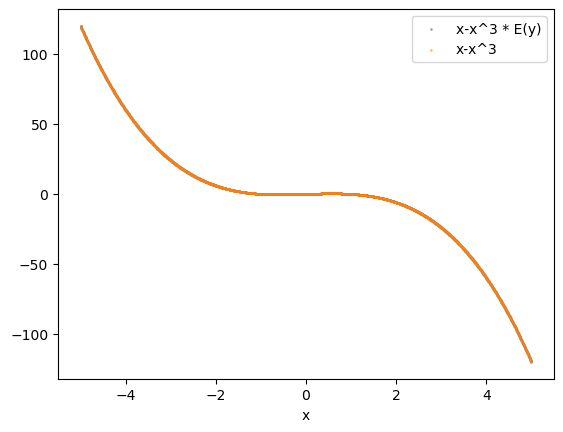

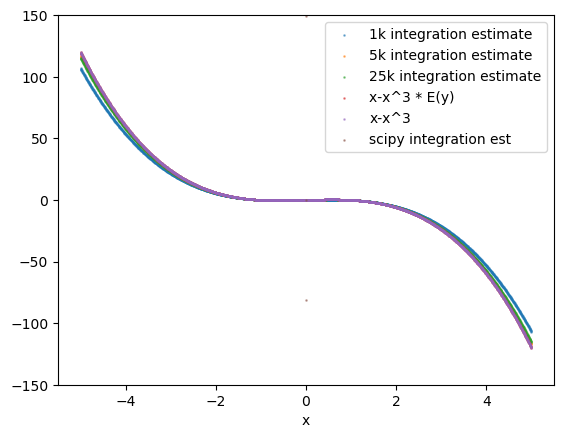

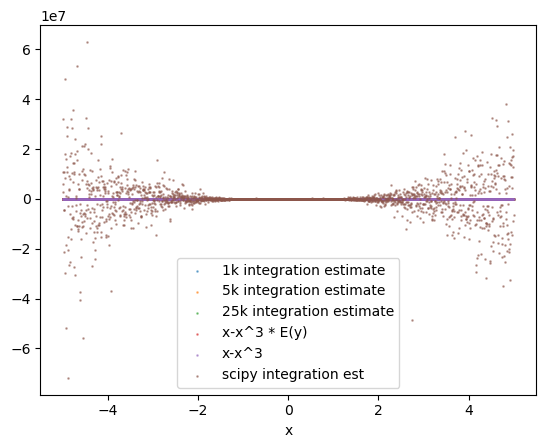

In [106]:
plt.scatter(x_vals, b_bar_manual, label='x-x^3 * E(y)', s=0.8, alpha=0.5)
plt.scatter(x_vals, x_vals-x_vals**3, label='x-x^3', s=0.8, alpha=0.5)
plt.xlabel('x')
plt.legend()
plt.show()

plt.scatter(x_vals, b_bar_est_1k, label='1k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_5k, label='5k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_25k, label='25k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_manual, label='x-x^3 * E(y)', s=0.8, alpha=0.5)
plt.scatter(x_vals, x_vals-x_vals**3, label='x-x^3', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_scipy[:,0], label='scipy integration est', s=0.8, alpha=0.5)
plt.xlabel('x')
plt.ylim(-150,150) # getting rid of this line shows the scipy-est vals, which are very random

plt.legend()
plt.show()

# same plot but with no y limit
plt.scatter(x_vals, b_bar_est_1k, label='1k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_5k, label='5k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_25k, label='25k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_manual, label='x-x^3 * E(y)', s=0.8, alpha=0.5)
plt.scatter(x_vals, x_vals-x_vals**3, label='x-x^3', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_scipy[:,0], label='scipy integration est', s=0.8, alpha=0.5)
plt.xlabel('x')

plt.legend()
plt.show()

E(y) = 1 above, since the truncation (at -100,100) is so much larger/farther than the variance (sigma^2 = 10) 

# Next, calculating the estimated and manual result for b2 = (x+y)-(x+y)^3

## Calculating the derivatives of the MGF for truncated normal, and evaluating at our values
https://en.wikipedia.org/wiki/Truncated_normal_distribution

In [52]:
import sympy as sp

# Define the symbolic variables
t, sigma, beta, alpha, mu = sp.symbols('t sigma beta alpha mu', real=True)

# Define the Phi function using SymPy's error function erf
def Phi(x):
    return 0.5 * (1 + sp.erf(x / np.sqrt(2)))

# Define the MGF for the truncated normal distribution
MGF = sp.exp(mu * t + 1/2*sigma**2*t**2) * (Phi(beta - sigma * t ) - Phi(alpha - sigma * t))/(Phi(beta) - Phi(alpha))

# Calculate derivatives
MGF_derivative = sp.diff(MGF, t)
MGF_second_derivative = sp.diff(MGF_derivative, t)
MGF_third_derivative = sp.diff(MGF_second_derivative, t)

# Define the specific values for sigma, beta, alpha, and mu
values = {sigma: scale, beta: b_trunc_real, alpha: a_trunc_real, mu: loc}

# Evaluate MGF, its first, and second, and third derivatives at t=0 with specific parameter values
MGF_at_0 = MGF.subs(values).subs(t, 0)
MGF_derivative_at_0 = MGF_derivative.subs(values).subs(t, 0)
MGF_second_derivative_at_0 = MGF_second_derivative.subs(values).subs(t, 0)
MGF_third_derivative_at_0 = MGF_third_derivative.subs(values).subs(t, 0)

# Print the values
print("The MGF at t=0 is:")
sp.pprint(MGF_at_0.simplify())

print("\nThe first derivative of the MGF at t=0 is:")
sp.pprint(MGF_derivative_at_0.simplify())

print("\nThe second derivative of the MGF at t=0 is:")
sp.pprint(MGF_second_derivative_at_0.simplify())

print("\nThe third derivative of the MGF at t=0 is:")
sp.pprint(MGF_third_derivative_at_0.simplify())

The MGF at t=0 is:
1.00000000000000

The first derivative of the MGF at t=0 is:
      3.3379063258461e-213
1.0 - ────────────────────
               √π         

The second derivative of the MGF at t=0 is:
       3.37128540286444e-211
11.0 - ─────────────────────
                 √π         

The third derivative of the MGF at t=0 is:
       3.37829499252644e-209
31.0 - ─────────────────────
                 √π         


In [54]:
# Setting these values based on the above
E_y2 = 11
E_y3 = 31

In [59]:
pi = trunc
b = b2_v
x = x_vals

np.random.seed(0)
b_bar2_est_5k = b_bar_v(x=x, pi=pi, b=b, integral_N=5000)
b_bar2_est_1k = b_bar_v(x=x, pi=pi, b=b, integral_N=1000)
b_bar2_est_25k = b_bar_v(x=x, pi=pi, b=b, integral_N=25000)

b_bar2_manual = x + E_y - x**3 + (3*x**2)*E_y + 3*x*E_y2 + E_y3

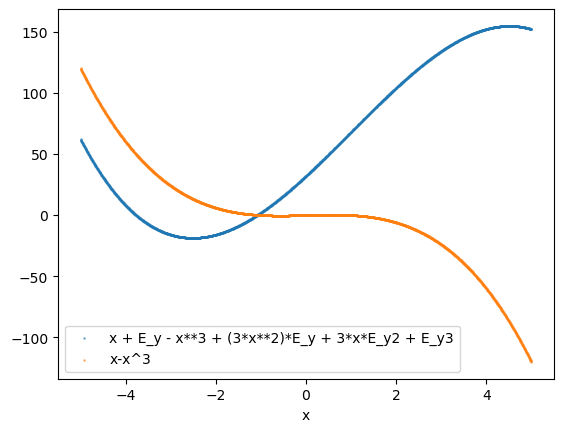

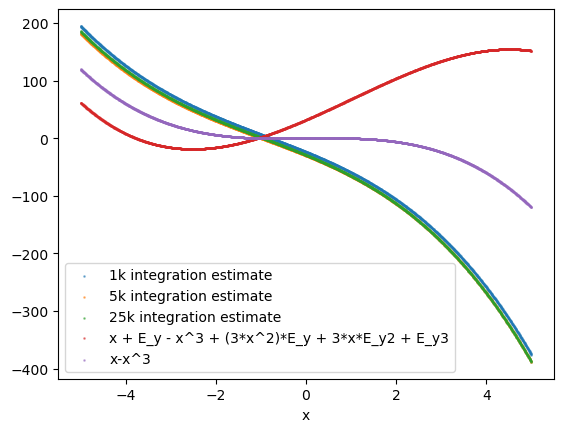

In [60]:
plt.scatter(x_vals, b_bar2_manual, label='x + E_y - x**3 + (3*x**2)*E_y + 3*x*E_y2 + E_y3', s=0.8, alpha=0.5)
plt.scatter(x_vals, x_vals-x_vals**3, label='x-x^3', s=0.8, alpha=0.5)
plt.xlabel('x')
plt.legend()
plt.show()

plt.scatter(x_vals, b_bar2_est_1k, label='1k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar2_est_5k, label='5k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar2_est_25k, label='25k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar2_manual, label='x + E_y - x^3 + (3*x^2)*E_y + 3*x*E_y2 + E_y3', s=0.8, alpha=0.5)
plt.scatter(x_vals, x_vals-x_vals**3, label='x-x^3', s=0.8, alpha=0.5)
plt.xlabel('x')

plt.legend()
plt.show()